# CA6011 Deep Learning for NLP: Week 4 Lab -- Recurrent Neural Networks

**Recurrent Neural Networks** (RNNs) are another type of artificial neural networks designed to process sequential data by maintaining a memory of previous inputs. Unlike feedforward neural networks (Week 2), where information flows only in one direction (from input to output), RNNs have connections that allow information to persist over time and influence the processing of subsequent inputs. This makes RNNs well-suited for tasks involving sequential data, such as speech recognition and handwriting recognition.

The success of Recurrent Neural Networks (RNNs) in modeling data hinges on their ability to maintain a form of short-term memory which is updated at each time step as new input is processed. Through the simple mechanism of copying the preceding hidden state and concatenating it to current inputs, this memory captures information about past inputs, allowing previous inputs to shape future outputs at each time step. See the lecture slides and references for details.

In this lab, you will code, more or less from scratch, a simple Recurrent Neural Network (sometimes called an Elman Network, see original paper in Week 4 Lab folder) and apply it to a sentiment classification task.

Here are two examples of the sentiment classification data we will use (for  more information see the Dataset Section (2.1) below):
 ```
   text: 'this is very good', label: True,
   text: 'i am sad right now', label: False,
 ```

As before, we provide a coding framework with a lot of the code in place, for you to add to.

The remainder of the lab (for which we don't provide solutions) is for you to complete on your own, and must be submitted for assessment for Week 4 of this module (see handbook).



Troughout this notebook we are going to refer to the lecture slides, and also [Speech and Language Processing (3rd ed. draft) Dan Jurafsky and James H. Martin](https://web.stanford.edu/~jurafsky/slp3/), this week specifically Sections 13.1-13.3.

In [81]:
# %matplotlib inline allows for displaying plots directly in the Jupyter notebook
%matplotlib inline
import numpy as np
# seed = 42
# np.random.seed(seed)

# Pytorch is Deep learning framework
import torch

# NumPy is a library for numerical computations, with support for arrays and matrices
import numpy as np

# tqdm is used for creating progress bars to track the progress of for loops
from tqdm import tqdm

# Matplotlib is a plotting library, and we use it for tracking the loss values across iterations
import matplotlib.pyplot as plt

# IPython.display allows clearing the output in a Jupyter notebook cell
from IPython.display import clear_output

# use F to import Tanh and softmax activation function
from torch.nn import functional as F

# Importing the random module for generating random numbers/orders
import random

# Importing the list data type for storing collections of items.
from typing import List

import torch.nn.init as init


## 1 Recurrent Neural Network Implementation


### 1.1 Activation Functions definition and derivatives

In our implementation, we'll use Tanh and Softmax as activation functions:
- **Tanh Function:**

  $ \tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$

  *Derivative with respect to **z**:*
  $\frac{d}{dz} \tanh(z) = (1 - \tanh(z)^2)$

- **Softmax Function:**

  $\text{softmax}(z_k) = \frac{e^{z_k}}{\sum_{j=1}^{k} e^{z_j}}$ , Where k is the number of classes

  *Derivative with respect to **z**$_k$:*
  $\frac{\partial}{\partial z_k} \text{softmax}(z_k) = \text{softmax}(z_k) \cdot (1 - \text{softmax}(z_k))$

**Note:** As discussed in previous lectures and labs, we require the derivatives of all function involved in forward propagation. These derivatives indicate how each weight and bias needs to be changed to minimise the loss function, forming the basis for the backward propagation loop for updating the weights and biases.

### 1.2 Backward Propagation definition

As explained in Week 2, the goal of backward propagation is to calculate the change to be made to each weight and bias on the basis of the loss we receive from the forward propagation. We need to change the weights and biases individually, because the loss is a function of all the weights and biases (i.e. many variables), so we use partial derivatives with respect to each weight and bias. Sed previous lectures for details.

In RNNs, backpropagation works pretty much the same way, with one small modification: the backward pass has to involve not just the current hidden state, but all previous hidden states in the current input sequence. For algorithmic simplicity, we `unroll' the network across time to obtain a single network that can be treated as a FNN for training and inference purposes. When backpropagation works like this it's called Backpropagetion through time (BPTT). See lectures and Jurafsky & Martin, Section 13.1 for details.

[Backpropagation through time (BPTT)](https://en.wikipedia.org/wiki/Backpropagation_through_time) is a gradient-based technique used to train Recurrent Neural Networks (RNNs). In RNNs, while weights and biases are shared across all time steps, it's crucial to track the changes in weights and biases corresponding to the received input at each time step. This tracking is accomplished by unrolling the recurrent connections, as shown in the lecture slides on Slide 13, replicating the weights shared across time steps, and feeding in the inputs received at time t, for each time step t.

In the **forward propagation** step for Elman RNNs, we compute the following operations and apply them recurrently for all time steps:


\begin{align*}
h_i &= g(Uh_{i-1} + Wx_i) \tag{1} \\
y_i &= f(Vh_i) \tag{2}
\end{align*}

Where:
- $x_i$ is the input at the current time step.
- $y_i$ is the output at the current time step.
- $h_i$ is the hidden state at the current time step.
- $h_{i-1}$ is the hidden state at the previous time step.
- $g$ is the hidden-layer activation function, Tanh usually
- $f$ is the activation function at the output layer, in our implementation we use softmax.
- $ U,  W, V$ are learnable weights matrices.


So, in the backward propagation step, we carry out the following backward differentiation computations (refer to Week 2 lecture and lab):

**Step 1: Compute Loss**

For a single time step $i$, let $L_i$ be the cross-entropy loss function:

$L_i = -\sum_{k} \hat{y}_{i,k} \log(y_{i,k})$

where $ \hat{y}_{i,k} $ is the true label for class $k$ and $ y_{i,k}$ is the predicted probability for class *k*.

**Step 2: Backpropagate Through Output Layer**

We compute the gradient of the loss with respect to the output prediction $ y_i$, denoted as $ \frac{\partial L_i}{\partial y_i} $, using the derivative of the cross-entropy loss function:
$
\frac{\partial L_i}{\partial y_{i,k}} = \frac{-\hat{y}_{i,k}}{y_{i,k}}
$

Using this gradient, we compute the gradients of the weights $ V$ connecting the hidden state $ h_i$ to the output layer:
$
\frac{\partial L_i}{\partial V} = \frac{\partial L_i}{\partial y_i} \cdot \frac{\partial y_i}{\partial V} = \frac{\partial L_i}{\partial y_i} \cdot h_i
$

**Step 3: Backpropagate Through Hidden Layer**

We backpropagate the gradients through the output layer to the hidden layer. We first compute the gradient of the loss with respect to the hidden state $ h_i $:
$
\frac{\partial L_i}{\partial h_i} = \frac{\partial L_i}{\partial y_i} \cdot \frac{\partial y_i}{\partial h_i} = V^T \cdot \frac{\partial L_i}{\partial y_i}
$

Then, we compute the gradients of the weights $ U $ and $ W $ connecting the previous hidden state $ h_{i-1} $ and the input $ x_i $ to the current hidden state $ h_i $, respectively:

$
\frac{\partial L_i}{\partial U} = \frac{\partial L_i}{\partial h_i} \cdot \frac{\partial h_i}{\partial U} = \frac{\partial L_i}{\partial h_i} \cdot h_{i-1}
$

$
\frac{\partial L_i}{\partial W} = \frac{\partial L_i}{\partial h_i} \cdot \frac{\partial h_i}{\partial W} = \frac{\partial L_i}{\partial h_i} \cdot x_i
$

**Step 4: Update Weights**

Finally, we update the weights $ U $, $ W $, and $ V $ using the computed gradients and a learning rate:

$$
U := U - \text{learning\_rate} \cdot \frac{\partial L_i}{\partial U}
$$

$$
W := W - \text{learning\_rate} \cdot \frac{\partial L_i}{\partial W}
$$

$$
V := V - \text{learning\_rate} \cdot \frac{\partial L_i}{\partial V}
$$

These equations represent the gradient updates for each parameter in the Elman-style RNN during the backpropagation through time process. They allow the network to adjust its weights to minimise the loss and improve its predictions over time.


### 1.3 Network definition

To create an Elman Recurrent Neural Network (RNN) and train it, we follow the same steps as in the Week 2 Lab (FNN implementation).
However, as we have become familiar with these implementations, we won't build everything from scratch, especially for activation functions. Instead, we will utilise their NumPy implementation, as we are already familiar with how to implement and use them.

Here's a quick reminder of those steps:

1. **Initialise Layers:**
   - For each layer, initialise a weight matrix:
      - The weight matrix **W**: here we need three weight matrices **W, U, V** as per equations 1 and 2 above.
      - Biases: we will add biases to the **U** and **V** weight matrices.

2. **Define Activation Functions for hidden state and output:**
   - Common choices for RNN include:
      - [Tanh](https://en.wikipedia.org/wiki/Hyperbolic_functions): use torch.tanh() instead of implementing the activation function from scratch
      - [Softmax](https://en.wikipedia.org/wiki/Softmax_function): we use a softmax from torch.nn.functional, take a look at the import cell, we imported "torch.nn.functional as F", to use softmax we will do (F.softmax()).

3. **Define Forward Propagation Function:**
   - Implement a function that computes the output of the neural network given an input and initial hidden state by applying the previous equations 1 and 2.


4. **Define Backward Propagation Function:**
   - Implement a function that computes the gradients of the loss with respect to the weights and biases by applying the chain rule of calculus across time steps.

5. **Define Training Loop:**
   - Iterate through the training data multiple times, performing the following in each iteration:
      - Forward pass to compute predictions.
      - Compute loss using the chosen loss function.
      - Backward pass to compute gradients.
      - Update weights and biases.
      - Repeat until the loss converges or a predefined number of iterations are reached.






**Note:** In this lab, we will use the @ operator or matmul function (i.e., matrix multiplication). As you are now well-versed in matrix multiplication (see Week 2 Lab), we will prefer to use this operator. Essentially, @ and np.dot behave similarly for 2D matrix multiplication, but @ is preferred for its readability and ease of debugging, as it's a bit challenging to implement RNNs compared to FFNs. The code may become messy with RNN implementations, making @ the preferred choice. For more information on the differences between these operators, you can refer to [this link](https://stackoverflow.com/questions/34142485/difference-between-numpy-dot-and-python-3-5-matrix-multiplication).



In [82]:
class ElmanRNN:

  # Step 1 Initialises the Elman-style RNN Architecture
  def __init__(self, input_size, output_size, embedding_dim, hidden_size=64):
    '''
        Initialises the Elman-style RNN with random weights and zero biases.

        Args:
          input_size (int): Number of features in the input data.
          hidden_size (int): Number of neurons in the hidden layer.
          output_size (int): Number of classes in the output layer.
    '''
    # Weights
    '''
    randn returns a sample from the standard normal distribution.
    We divide by 1000 (just a value that seems to work with our setup).
    The goal is to have a better initialisation.
    The ultimate objective of different initialisation techniques is
    to ensure that our weights are neither too small nor too large,
    as this has a significant impact on training dynamics and neural network stability.
    '''
    self.hidden_size = hidden_size #make hidden size accessable to other functions in the class
    self.embeddings = {}

    # Weight matrices
    # self.U = torch.randn(hidden_size, hidden_size) / 1000
    # self.W = torch.randn(hidden_size, embedding_dim) / 1000
    # self.V = torch.randn(output_size, hidden_size) / 1000
    # self.E = torch.randn(embedding_dim, input_size) / 1000
    self.U = torch.empty(hidden_size, hidden_size)
    self.W = torch.empty(hidden_size, embedding_dim)
    self.V = torch.empty(output_size, hidden_size)
    self.E = torch.empty(embedding_dim, input_size)

    # Xavier init
    gain_tanh = init.calculate_gain("tanh")  # because hidden uses tanh
    init.xavier_uniform_(self.U, gain=gain_tanh)
    init.xavier_uniform_(self.W, gain=gain_tanh)
    init.xavier_uniform_(self.V)             # output layer: gain=1 is usually fine
    init.xavier_uniform_(self.E) 

    # Biases
    self.BU = torch.zeros(hidden_size, 1)
    self.BV = torch.zeros(output_size, 1)

  # Step 2: For activation functions, we will use their torch implementation instead of from-scratch

  # Step 3: Perform Forward propagation
  def forward(self, inputs, verbose:bool=False):
    '''
    Perform a forward pass of the RNN using the given inputs.
    Returns the final output and hidden state.
    - inputs is a list of arrays of one hot vectors with shape (input_size, 1) for each word in the sentence.
    - verbose: it's a common flag in programming, enable if you want to print meta information about your function.
    '''
    ## INSERT YOUR CODE HERE ##
    #initialise the hidden state to zero -> h: (self.hidden_size, 1)
    h = torch.zeros((self.hidden_size, 1))

    # store information for backward pass:

    # store the inputs which represent all sequences
    self.all_sequences = inputs

    # initialise a dict to store all hidden states, for this dict the key is the index of the time step,
    # and the value is the hidden state (h) at that step. Our first hidden state is the initialised one above,
    # and because we haven't started processing any input yet, we will give it time step index 0.
    self.previous_hidden_states = {0:h}
    self.embeddings = {}

    # Perform RNN for each time step, the input for each time step is x
    for i, x in enumerate(inputs):
      # calculate the next hidden state using equation 1
      # W (hidden_size, input_size) @ x (input_size, 1) -> (hidden_size, 1)
      # U (hidden_size, hidden_size) @ h (hidden_size, 1) -> (hidden_size, 1)
      e = self.E @ x
      self.embeddings[i+1] = e
      h = torch.tanh(self.U @ h + self.W @ e + self.BU)

      # store this hidden state in self.previous_hidden_states.
      # we already indexed the hidden state at step 0, the for loop counts from (0->(N-1))
      # we need to take care of that by adding 1 to the for loop counter.
      self.previous_hidden_states[i+1] = h

    if verbose:
      print(f"Hidden state size: {h.shape}")
      print(f"Hidden states: {self.previous_hidden_states}")

    # Compute the output using equation 2 and the last hidden state
    # V (output_size, hidden_size) @ h (hidden_size, 1) -> (output_size, 1)
    # Softmax has an argument called 'dim' that specifies the index dimension for applying softmax.
    # Applying softmax to the 'output_size' dimension provides the label distribution (which we are intreseted in).
    # Determine the index of the 'output_size' dimension to use as the value for 'dim'.
    y = F.softmax((self.V @ h + self.BV), dim=0)

    if verbose:
      print(f"Output size: {y.shape}")

    # return the output (y) and the last hidden state (h)
    return y, h

    ## END OF YOUR CODE ##

  # Step 4: Perform Backward propagation
  def backward_through_time(self, outputs, y, learn_rate=2e-2):
    '''
    Perform a backward pass of the RNN.
    - outputs: network predictions.
    - y: ground truth labels (targets).
    - learn_rate is a float.
    '''
    n = len(self.all_sequences)

    # Backpropagate through Output Layer:
    #target_labels or y  = 0 #index of correct label
    #outputs =[0.2, 0.8] #predictions
    #we will copy the outputs to variable d_y to indicate that,
    #we want the change in prediction compared to the target index
    #so that we can propagate this change to the network, to make better predictions the next time.
    #so d_y[y] = -0.8 (0.2 - 1)  and this is what our neural network needs to care about.
    d_y = outputs
    d_y[y] -= 1

    # Calculate dL/dV and dL/dBV.
    # Since the output vectors and the one-hot encoded target vectors(y) have different dimensions,
    # we perform the matrix multiplication using the transpose of the hidden state matrix (self.previous_hidden_states[n].T),
    # which matches the dimensionality of the output vectors.
    d_V = d_y @ self.previous_hidden_states[n].T
    d_BV = d_y

    # Backpropagate through time:
    # Initialise dL/dU, dL/dW, and dL/dBU to zero, because those are the sets of parameters,
    # to accumulate their gradients across all time steps.
    d_U = torch.zeros(self.U.shape)
    d_W = torch.zeros(self.W.shape)
    d_BU = torch.zeros(self.BU.shape)
    d_E = torch.zeros(self.E.shape)

    # Calculate dL/dh for the last h.
    # dL/dh = dL/dy * dy/dh
    d_h = self.V.T @ d_y

    for t in reversed(range(n)):
      # Backpropagate through Hidden Layer:
      # An intermediate value: dL/dh * (1 - h^2)
      # (1 - h^2) is Tanh derivative
      d_h_raw = ((1 - self.previous_hidden_states[t + 1] ** 2) * d_h)

      # dL/dBU = dL/dh * (1 - h^2)
      d_BU += d_h_raw

      # dL/dU = dL/dh * (1 - h^2) * h_{t-1}
      d_U += d_h_raw @ self.previous_hidden_states[t].T

      # dL/dW = dL/dh * (1 - h^2) * x
      e_t = self.embeddings[t+1]
      d_e_t = self.W.T @ d_h_raw

      x_t = self.all_sequences[t]
      d_E += d_e_t @ x_t.T
      
      d_W += d_h_raw @ e_t.T

      # Update hidden state gradient for next time step:
      # Next dL/dh = dL/dh * (1 - h^2) * U
      d_h = self.U.T @ d_h_raw

    # Clip to prevent exploding gradients. RNN and its variants suffer alot from this problem
    for d in [d_W, d_U, d_V, d_BU, d_BV, d_E]:
      torch.clip(d, -1, 1, out=d)

    # Update weights and biases using gradient descent.
    self.U -= learn_rate * d_U
    self.W -= learn_rate * d_W
    self.V -= learn_rate * d_V
    self.BU -= learn_rate * d_BU
    self.BV -= learn_rate * d_BV
    self.E -= learn_rate * d_E

  # Step 5: Training Loop
  def train(self, trainset_inputs: List[List[torch.tensor]], trainset_targets: List[List[torch.tensor]], epochs: int=100, learning_rate: float=0.01) -> None:
          '''
              Trains the Elman-style RNN using the specified training data.

              Args:
                trainset_inputs: contain input samples
                trainset_tragets: contain the corresponding labels.
                epochs (int): Number of training epochs. Default to 100.
                learning_rate (float): Learning rate for weight updates. Default to 0.01.
          '''

          self.losses = []
          for i, epoch in enumerate(range(epochs)):
              loss = 0
              num_correct = 0
              for x, y in zip(trainset_inputs, trainset_targets):
                  # Forward pass
                  outputs, _ = self.forward(x)
                  # Compute cross entropy loss/ Accuracy
                  loss -= torch.log(outputs[y])
                  num_correct += int(torch.argmax(outputs) == y)

                  # Backward pass through time
                  self.backward_through_time(outputs, y, learning_rate)

              self.losses.append((loss / len(trainset_inputs)).item())
              print(f"Train set accuracy at final Epoch {i+1}: {num_correct / len(trainset_inputs)}")


  def show_learning_curve(self) -> None:
        '''
        Displays the learning curve (loss curve) during training.
        '''
        plt.plot(self.losses)
        plt.xlabel('Epochs') # x axis label
        plt.ylabel('Cross-Entropy Loss') # y axis label
        plt.show()


  def test(self, testset_inputs: List[List[torch.tensor]], testset_targets: List[List[torch.tensor]]) -> float:
        '''
        Calculates the predictions for the given samples.

        Args:
            testset_inputs: contains test samples.
            testset_targets: contain the corresponding labels

        Returns:
            Accuracy: int
        '''
        num_correct = 0
        for x, y in zip(testset_inputs, testset_targets):
            y_pred, _ = self.forward(x)
            num_correct += int(torch.argmax(y_pred) == y)
        return num_correct / len(testset_inputs)


As we explained in the Week 2 Lab, we should test our neural network using a dummy dataset to ensure that everything is working as intended before committing to training on a real dataset.

In [83]:
# Assuming X is a sentence that contains a variable length of words, and each words has specific hidden size.
# RNN will receive each word sequentially at a different time step and maintain a hidden state for them.

sequence_length = 3 # we have three words in this sentence
X = [torch.randn(18, 1)] * sequence_length  # Dummy input data

#Assuming y classify our sentence to two classes (positive or negative)
y = torch.randint(0, 2, size=(1,))  #Dummy target labels (2 classes)

In [84]:
input_size = 18
output_size = 2 #num classes
emedding_dim = 64
# hidden size is by default set to 64, feel free to tweak it
model = ElmanRNN(input_size, output_size, emedding_dim)

In [85]:
# we enable verbose, to print the matrix sizes in the forward function
predictions, hidden_state = model.forward(X, verbose=True)
print(predictions)

Hidden state size: torch.Size([64, 1])
Hidden states: {0: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]), 1: tensor([[-0.7835],
        [ 0.8602],
   

Now let's try the backward pass:

In [86]:
# if this runs without error, we are safe. backward doesn't return any value,
# just changing the global variables of the parameters.
model.backward_through_time(predictions, y)

Seems our RNN is working as intended, now let's go ahead and train a classification model using a real dataset.

## 2 Train a sentiment classification model with RNNs




#### 2.1 Dataset

The overall goal of sentiment classification is to automatically identify the sentiment conveyed by a text, and assign each text to predefined categories such as positive and negative (below True and False, respectively).

We use the following [data](https://github.com/ramnathv/rnn-from-scratch-1/blob/master/data.py) to train our RNN. In the next cell you will see two dictionaries, the first for the train set with 58 train items, and the second for the test set with 20 test items, each containing the input text as the dictionary key and the class label (True=positive or False=negative) as the corrsponding value.


In [87]:
train_data = {
  'good': True,
  'bad': False,
  'happy': True,
  'sad': False,
  'not good': False,
  'not bad': True,
  'not happy': False,
  'not sad': True,
  'very good': True,
  'very bad': False,
  'very happy': True,
  'very sad': False,
  'i am happy': True,
  'this is good': True,
  'i am bad': False,
  'this is bad': False,
  'i am sad': False,
  'this is sad': False,
  'i am not happy': False,
  'this is not good': False,
  'i am not bad': True,
  'this is not sad': True,
  'i am very happy': True,
  'this is very good': True,
  'i am very bad': False,
  'this is very sad': False,
  'this is very happy': True,
  'i am good not bad': True,
  'this is good not bad': True,
  'i am bad not good': False,
  'i am good and happy': True,
  'this is not good and not happy': False,
  'i am not at all good': False,
  'i am not at all bad': True,
  'i am not at all happy': False,
  'this is not at all sad': True,
  'this is not at all happy': False,
  'i am good right now': True,
  'i am bad right now': False,
  'this is bad right now': False,
  'i am sad right now': False,
  'i was good earlier': True,
  'i was happy earlier': True,
  'i was bad earlier': False,
  'i was sad earlier': False,
  'i am very bad right now': False,
  'this is very good right now': True,
  'this is very sad right now': False,
  'this was bad earlier': False,
  'this was very good earlier': True,
  'this was very bad earlier': False,
  'this was very happy earlier': True,
  'this was very sad earlier': False,
  'i was good and not bad earlier': True,
  'i was not good and not happy earlier': False,
  'i am not at all bad or sad right now': True,
  'i am not at all good or happy right now': False,
  'this was not happy and not good earlier': False,
}

test_data = {
  'this is happy': True,
  'i am good': True,
  'this is not happy': False,
  'i am not good': False,
  'this is not bad': True,
  'i am not sad': True,
  'i am very good': True,
  'this is very bad': False,
  'i am very sad': False,
  'this is bad not good': False,
  'this is good and happy': True,
  'i am not good and not happy': False,
  'i am not at all sad': True,
  'this is not at all good': False,
  'this is not at all bad': True,
  'this is good right now': True,
  'this is sad right now': False,
  'this is very bad right now': False,
  'this was good earlier': True,
  'i was not happy and not good earlier': False,
}

To encode our text data into a numerical format, we will follow a two-step process:

- Indexing (i.e. tokenizing): We will assign a unique index to each word in the text corpus. This step involves creating a dictionary where each word is mapped to a unique integer index.

- One-Hot Encoding (vector representation of words): After indexing the words, we will represent each word as a one-hot encoded vector. In this encoding scheme, each word is represented as a binary vector where all elements are zero except for the index corresponding to the word, which is set to one.

For example:
Word to Index Mapping: {'Recurrent': 0, 'Neural': 1, 'Network': 2}
One-Hot Encoded Data:
- Recurrent: [1, 0, 0]
- Neural:    [0, 1, 0]
- Network:   [0, 0, 1]

In [88]:
# Create the vocabulary.

# get unique words in the training corpus: set() removes duplicates
vocab = list(set([w for text in train_data.keys() for w in text.split(' ')]))
vocab_size = len(vocab)
print('%d unique words found' % vocab_size)

# Assign indices to each word.
word_to_idx = { w: i for i, w in enumerate(vocab) }
# test getting the index for one of the words from our dataset
print(word_to_idx['good'])

def createInput(text):
  '''
  Returns an array of one-hot vectors representing the words in the input text string.
  - text is a string
  - Each one-hot vector has shape (vocab_size, 1)
  '''
  inputs = []
  for w in text.split(' '):
    v = torch.zeros(vocab_size, 1)
    v[word_to_idx[w]] = 1
    inputs.append(v)
  return inputs

18 unique words found
10


In [89]:
def processData(data: dict)-> tuple:
  '''
    Process the input data for training or inference.

    Args:
        data (dict): A dictionary containing input-output pairs.
    Returns:
        tuple: A tuple containing processed inputs and targets.
  '''
  items = list(data.items())
  random.shuffle(items)
  inputs = []
  targets = []
  for x, y in items:
    inputs.append(createInput(x))
    targets.append(int(y))
  return inputs, targets

### 2.2 Initialise a new instance of the ElmanRNN  and set the the proper sizes

Train set accuracy at final Epoch 1: 0.41379310344827586
Train set accuracy at final Epoch 2: 0.39655172413793105
Train set accuracy at final Epoch 3: 0.46551724137931033
Train set accuracy at final Epoch 4: 0.5172413793103449
Train set accuracy at final Epoch 5: 0.5689655172413793
Train set accuracy at final Epoch 6: 0.603448275862069
Train set accuracy at final Epoch 7: 0.603448275862069
Train set accuracy at final Epoch 8: 0.6379310344827587
Train set accuracy at final Epoch 9: 0.6551724137931034
Train set accuracy at final Epoch 10: 0.6724137931034483
Train set accuracy at final Epoch 11: 0.6896551724137931
Train set accuracy at final Epoch 12: 0.7241379310344828
Train set accuracy at final Epoch 13: 0.7413793103448276
Train set accuracy at final Epoch 14: 0.7413793103448276
Train set accuracy at final Epoch 15: 0.7413793103448276
Train set accuracy at final Epoch 16: 0.7413793103448276
Train set accuracy at final Epoch 17: 0.7586206896551724
Train set accuracy at final Epoch 18: 0

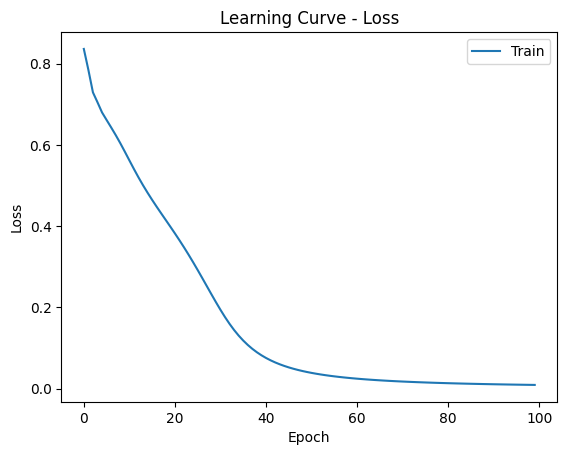

In [90]:
## INSERT YOUR CODE HERE ##
# Initialise our Elman-style RNN
input_size = vocab_size # number of words in the vocabulary
output_size =  2 #num classes
emedding_dim = 8
# hidden size is by default set to 64, feel free to tweak it
model = ElmanRNN(input_size, output_size, emedding_dim)


# before start training, process train set dict using processData function:
x_train, y_train = processData(train_data)

#train the Elman-style RNN
model.train(x_train, y_train, epochs=100, learning_rate=0.01)
'''predictions, hidden_state = model.forward(X, verbose=True)
print(predictions)
model.backward_through_time(predictions, y_train)'''

#plot the learning curve
plt.plot(model.losses, label='Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve - Loss')
plt.legend()

## END OF YOUR CODE ##

### 2.3 Evaluate the trained model

In [91]:
## INSERT YOUR CODE HERE ##

# process test set dict using processData function:
x_test, y_test = processData(test_data)

# test your model

accuracy = model.test(x_test, y_test)

# print Accuracy
print(f"Test set accuracy: {accuracy}")
## END OF YOUR CODE ##

Test set accuracy: 0.95


## Week 4 Submission Task: Improve performance and explore different text encoding techniques

In previous labs, we explored various techniques for encoding text into numerical values.
In the Week 1 Lab, the natural logarithm of text length and the count of sport-related words were utilised. In the Week 2 Lab, TF-IDF was applied. In this Lab, one-hot encoding was used above.

To improve the performance of the network, your submission task is to add an embeddings layer to map the one-hot representations to word embeddings via an embeddings matrix E. The embeddings will then be multiplied with the weight matrix W, to feed into the hidden layer at the current time step.

Extension task (voluntary): There are are other ways you can try to improve performance, including different initialisations, increasing the training set size, reducing overfitting, and so on. Feel free to try any and all of these.


1. Adding hyperparameter emedding_dim which will be of my choice 8,16,32, 100 whatever
2. Add E weight matrix and change W (Dividing by 1000 so as not too large, makes weights very small, gradients are less llikely to explode or vanish immediately)
    `self.W = torch.randn(hidden_size, embedding_dim) / 1000`
    `self.E = torch.randn(embedding_dim, input_size) / 1000`
3. in foward()
`      e = self.E @ x`

      `h = torch.tanh(self.U @ h + self.W @ e + self.BU)`

# Resources

- Speech and Language Processing (3rd ed. draft) Dan Jurafsky and James H. Martin [Chapter 13](https://web.stanford.edu/~jurafsky/slp3/13.pdf)
- Goodfellow et al., [Sections 10.2–10.2.2](https://www.deeplearningbook.org/contents/rnn.html)
